In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra, operators
from pyiga import algebra_cy

from scipy.sparse.linalg import aslinearoperator

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [148]:
class IetiMapper:
    def __init__(self, MP, dir_data, neu_data=None, elim=False):
        self.space = MP
        self.numpatches = self.space.numpatches
        self.numdofs = self.space.N_ofs[-1]
        
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos

        self.elim=elim

        self.B = self.space.B
        self.N = self.space.N
        self.N_ofs = self.space.N_ofs

        self.dir_idx = dict()
        self.dir_vals = dict()

        for key in dir_data:
            for p,b in self.space.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], [(b//2,b%2)], dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(np.concatenate(self.dir_idx[p]), return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
            
        self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])

        # if self.elim:
        #     p_intfs = np.array([[p1,p2] for (p1,_,_),(p2,_,_),_ in self.space.intfs], dtype=np.int32).T
        #     self.Basisk, self.N_ofs, self.N, self.B = ieti_cy.pyx_compute_decoupled_coarse_basis(self.space.Basis.tocsc(), MP.N_ofs.astype(np.int32), p_intfs)
        # else:
            #self.Basisk = [scipy.sparse.identity(self.space.N[p]) for p in range(self.space.numpatches)]

        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.space.numpatches)]

        nnz_per_col = self.B.getnnz(axis=0)
        self.intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.space.global_dir_idx)
        self.skeleton = np.union1d(self.intfs, self.space.global_dir_idx)
        
        self.R_interior = self.numpatches*[None] ###TODO: without loops
        self.R_skeleton = self.numpatches*[None]
        self.R_interfaces = {}
        
        for p in range(self.space.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask_skeleton = np.zeros(self.N[p], dtype=bool)
            intfs = np.where(self.Bk[p].getnnz(0) > 0)[0]
            #mask_skeleton[intfs]=True
            mask_interior = np.ones(self.N[p], dtype=bool)
            mask_interior[intfs]=False
            if p in self.dir_idx:
                mask_interior[self.dir_idx[p]]=False
                #mask_skeleton[self.dir_idx[p]]=False
            self.R_interior[p]=Id[mask_interior]
            for b in range(4):
                if not any([(p,b) in self.space.mesh.outer_boundaries[key] for key in self.space.mesh.outer_boundaries]):
                    mask_intf = np.zeros(self.N[p], dtype=bool)
                    interface_dofs = assemble.boundary_dofs(kvs[p],bdspec=[(b//2,b%2)],ravel=True)
                    mask_intf[interface_dofs] = True
                    if p in self.dir_idx:
                        mask_intf[self.dir_idx[p]]=False
                    mask_skeleton += mask_intf
                    self.R_interfaces[(p,b)] = Id[mask_intf]
            self.R_skeleton[p] = Id[mask_skeleton]

    def nodes_as_primals(self, dir_boundary=False):  ###TODO: cythonize(?)
        """Get global vertices of the multipatch object as well as local nodal degrees of freedom corresponding to the vertices. 
        In case of T-junctions also obtain the $p$ global degrees of freedom and $p$ local degrees of freedom on the coarse patch.
        Additionally may include nodes on the Dirichlet boundary if desired."""
        self.corners = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=True) + self.N_ofs[p] for p, kvs in enumerate(self.space.mesh.kvs)])
        n = self.space.B.shape[1]

        idx = (self.space.B[:,self.corners]>0).getnnz(1)>0
        B = self.space.B[idx,:]
        B = B[B.getnnz(1)==2,:]
        loc_c = np.unique(B.indices)
        R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),n)).tocsr()
        c_B = B@R.T

        R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),n)).tocsr()
        nodal_indicator = algebra_cy.pyx_compute_basis(c_B.shape[0], c_B.shape[1], c_B, maxiter=10)
        
        dofs = np.empty(nodal_indicator.shape[1], dtype=np.int32)
        S = c_B.sum(0).A[0]
        for j in range(nodal_indicator.shape[1]):
            ind = nodal_indicator.indices[nodal_indicator.indptr[j]:nodal_indicator.indptr[j+1]]
            dofs[j]=R.indices[ind[np.argmax(S[ind])]]
        nodal_indicator = (R.T@nodal_indicator)[:,nodal_indicator.getnnz(axis=0)>1]
        nnz = self.space.B.getnnz(1)
        B = self.space.B.tocsc()
        constr = np.repeat(-1,len(dofs))

        for j in range(nodal_indicator.shape[1]):
            dof=dofs[j]
            for r in range(B.indptr[dof],B.indptr[dof+1]):
                i=B.indices[r]
                if nnz[i]>2:
                    constr[j]=i
                    break
                    
        if any(constr!=-1):
            idx = np.where(constr!=-1)[0]
            res = scipy.sparse.csc_matrix(nodal_indicator.shape)
            Q = scipy.sparse.coo_matrix((np.ones(len(idx)),(idx,np.arange(len(idx)))),(len(constr),len(idx)))
            res = (Q@abs(MP.B[constr[idx],:])).T
            res.data=res.data-1
            res.eliminate_zeros()
            res.data=res.data+1
            nodal_indicator += res
        return nodal_indicator
        
    #def averages_as_primals(self):

In [476]:
class PrimalSystem():
    def __init__(self, Prim):
        self.Prim = Prim
        self.nPrim = self.Prim.shape[1]

        self.Psi = scipy.sparse.csc_matrix((0,self.nPrim))
        self.A_prim = np.zeros(2*(self.nPrim,))
        self.RHS_prim = np.zeros(self.nPrim)
        self.R = []

    def incorporate_PrimalConstraints(self, A, B, RHS, IMap):
        if self.nPrim == 0:
            return A, B, RHS
        K = len(A)
        C=[]
        for p in range(K):
            c = self.Prim[IMap.N_ofs[p]:IMap.N_ofs[p+1],:].T
            jj = np.where((c.indptr[1:]-c.indptr[:-1])>0)[0]
            c = c[c.getnnz(1)>0,:]
            C.append(c)
            self.R.append(scipy.sparse.coo_matrix((np.ones(c.shape[0]),(np.arange(c.shape[0]),jj)),(c.shape[0],self.nPrim)))
            
        self.nPrimConstr = [c.shape[0] for c in C]

        mod_A = [scipy.sparse.bmat([[A[p],C[p].T],[C[p], None]]) for p in range(K)]
        mod_RHS = [np.concatenate([RHS[p],np.zeros(self.nPrimConstr[p])]) for p in range(K)]

        corner_idx = np.ones(IMap.numdofs) ###TODO: add this to Ieti Mapper and remove constraints there, so nLagrangeMultiplier is fixed in init already.
        corner_idx[IMap.corners]=0
        B_full = scipy.sparse.hstack(B, format='csc')@scipy.sparse.spdiags(corner_idx, 0, IMap.numdofs, IMap.numdofs)
        keep = (B_full.getnnz(1)>0)
        self.nLagrangeMultipliers= keep.sum()
        mod_B = [scipy.sparse.hstack([B[p][keep,:],scipy.sparse.csr_matrix((self.nLagrangeMultipliers, self.nPrimConstr[p]))]) for p in range(K)]
        return mod_A, mod_B, mod_RHS
        
    def compute_PrimalBasis(self, mod_A, mod_B, mod_RHS):
        loc_solver=[solvers.make_solver(a, spd=False, symmetric=True) for a in mod_A]
        self.Psi = []
        Delta = []
        self.B_prim = np.empty((self.nLagrangeMultipliers,self.nPrim))
        for p in range(len(mod_A)):
            RHS = scipy.sparse.vstack([scipy.sparse.csr_matrix((loc_solver[p].shape[0]-self.nPrimConstr[p],self.nPrimConstr[p])), scipy.sparse.identity(self.nPrimConstr[p])]).toarray()
            sol = loc_solver[p]@RHS
            psi, delta = sol[:(-self.nPrimConstr[p]),], sol[(-self.nPrimConstr[p]):,]
            if psi.ndim==1: psi=psi[:,None]
            if delta.ndim==1: delta=delta[:,None]
            Delta.append(delta)
            self.Psi.append(psi@self.R[p])
            self.A_prim -= self.R[p].T@delta@self.R[p]
            self.B_prim += mod_B[p][:,:-self.nPrimConstr[p]]@self.Psi[-1]
            self.RHS_prim += self.Psi[-1].T@mod_RHS[p][:-self.nPrimConstr[p]]
        return loc_solver

    def distribute_PrimalSolution(self, u_prim):
        return self.Psi@u_prim
        

In [544]:
class IetiSystem():
    def __init__(self, A, B ,RHS, loc_solver = None, spd=False, symmetric=False):
        self.A = A
        self.B = B
        self.RHS = RHS

        if loc_solver:
            assert len(loc_solver)==len(A), 'amount of local solvers does not match amount of local system matrices!'
            self.loc_solver=loc_solver
        else:
            self.loc_solver = [solvers.make_solver(a, spd=spd, symmetric=symmetric) for a in self.A]

        self.sanity_check()
        self.K = len(A)
        self.nLagrangeMultipliers = self.B[0].shape[0]

    def SaddlePointSystem(self, format='coo'):
        B = scipy.sparse.hstack(self.B)
        return scipy.sparse.bmat([[scipy.sparse.block_diag(self.A),B.T],[B,None]], format=format)

    def RHSforSaddlePointSystem(self):
        return np.concatenate(self.RHS+[np.zeros(self.nLagrangeMultipliers)])

    def SchurComplement(self, as_matrix=False):
        F = operators.SumOperator([aslinearoperator(self.B[p])@self.loc_solver[p]@aslinearoperator(self.B[p].T) for p in range(self.K)])
        if as_matrix:
            return F@np.eye(F.shape[1])
        return F

    def RHSforSchurComplement(self):
        return np.sum([self.B[p]@(self.loc_solver[p]@self.RHS[p]) for p in range(self.K)], axis=0)

    def constructSolutionFromLagrangeMultipliers(self, lam):
        np.concatenate([self.loc_solver@(RHS[p]-self.B[p].T@lam) for p in range(self.K)])
        
    def sanity_check(self):
        assert len(A)==len(B)==len(RHS), 'Length of input data incompatible!'
        K = len(A)
        assert np.all([B[0].shape[0]==B[p].shape[0] for p in range(K)]), 'Constraint matrices have incompatible number of constraints!'
        assert np.all([self.A[p].shape[0]==self.A[p].shape[1] for p in range(K)]), 'Local system matrices are not square!'
        assert np.all([self.B[p].shape[1] == self.A[p].shape[1] for p in range(K)]), 'Constraint matrices have incompatible dimension!'
        assert np.all([self.A[p].shape[0]==len(self.RHS[p]) for p in range(K)]), 'Local rhs vectors have incompatible dimension!'

In [ ]:
#class MsD_prec

setting up constraints took 0.007303476333618164 seconds.
Basis setup took 0.002480030059814453 seconds
pcg with preconditioned condition number κ ~ 22.180634137362905 stopped after 30 iterations with relres 5.194140759044084e-07


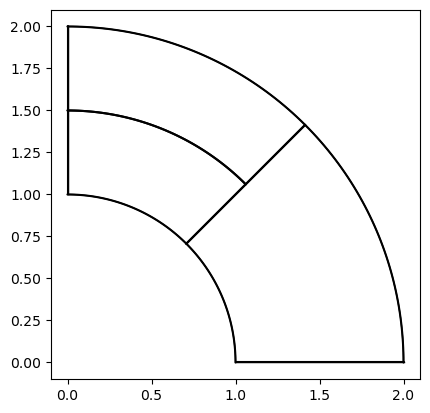

In [545]:
deg = 2
N = 3
#M = Tshapes(deg,N,1)
knots = (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
M = topology.PatchMesh([(knots,geometry.quarter_annulus())])
M.split_patch(0,axis=0);
M.split_patch(1,axis=1);
#M.split_patch(0,axis=1);

f={0:lambda x,y: 1.}
a = {0:1.}
dir_data = {0:0}

M.draw()
MP = assemble.Multipatch(M, automatch=True)
MP.set_dirichlet_boundary(dir_data)

A = [assemble.assemble('a*inner(grad(u),grad(v)) * dx', kvs, a=a[M.patch_domains[k]], geo=geo) for k, ((kvs, geo),_) in enumerate(M.patches)]
RHS = [assemble.assemble('f * v * dx', kvs, geo=geo, f=f[M.patch_domains[k]]).ravel() for k, ((kvs,geo),_) in enumerate(M.patches)]

IMap = IetiMapper(MP,dir_data)
B = IMap.Bk
primal = PrimalSystem(IMap.nodes_as_primals())
A, B, RHS = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
loc_solver = primal.compute_PrimalBasis(A, B, RHS)
#A, B ,RHS, loc_solver = A + [primal.A_prim], B + [primal.B_prim], RHS + [primal.RHS_prim], loc_solver + [solvers.make_solver(primal.A_prim, spd=True, symmetric=True)]
I = IetiSystem(A, B, RHS)
F, b = I.SchurComplement(), I.SchurRHS()

lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=1, rtol=1e-6, atol=1e-12)

In [540]:
F@lam-b

array([-4.66691e-08, -4.86842e-08, -3.07820e-09, -2.77556e-17,  1.33613e-07,  9.10244e-08,  1.39248e-07, -2.77556e-17, -4.39993e-08,  7.94721e-08,  1.69391e-08])

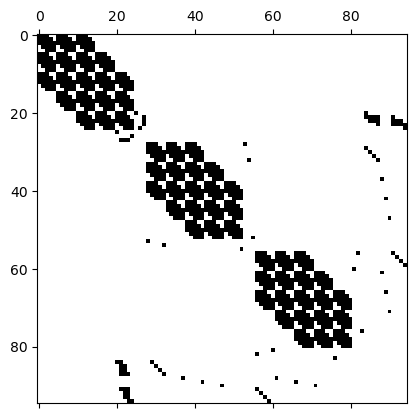

In [542]:
spy(I.SaddlePointSystem().toarray())

In [543]:
I.RHS_for_SaddlePointSystem()

array([0.00968, 0.02234, 0.04021, 0.03128, 0.01713, 0.02018, 0.04656, 0.08381, 0.06519, 0.0357 , 0.03175, 0.07327, 0.13189, 0.10258, 0.05618, 0.02187, 0.05047, 0.09085, 0.07066, 0.03869, 0.01106, 0.02552, 0.04594, 0.03573, 0.01957, 0.     , 0.     , 0.     , 0.00532, 0.01148, 0.01914, 0.01404, 0.00744, 0.01051, 0.02271, 0.03785, 0.02776, 0.01472, 0.01527, 0.03297, 0.05495, 0.0403 , 0.02137, 0.0097 , 0.02095, 0.03492, 0.02561, 0.01358, 0.00465, 0.01005, 0.01675, 0.01229, 0.00652, 0.     , 0.     , 0.     , 0.00787, 0.01659, 0.0268 , 0.01914, 0.01   , 0.01556, 0.03281, 0.05299, 0.03785, 0.01977, 0.02259, 0.04763, 0.07694, 0.05495, 0.0287 , 0.01436, 0.03027, 0.04889, 0.03492, 0.01824, 0.00689, 0.01452, 0.02346, 0.01675, 0.00875, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ])

In [503]:
primal.A_prim

array([[ 0.68888, -0.05071, -0.51886, -0.11931],
       [-0.05071,  0.72935, -0.57239, -0.10626],
       [-0.51886, -0.57239,  1.32302, -0.23177],
       [-0.11931, -0.10626, -0.23177,  0.45734]])

In [459]:
I.SchurComplement()

<68x68 SumOperator with dtype=float64>

In [462]:
primal.B_prim.shape

(68, 4)

In [354]:
I.SchurRHS()

array([1.40163e-01, 1.20838e-01, 6.25963e-09, 1.14388e-01, 1.44384e-01, 5.79492e-09, 1.59668e-01, 1.45452e-01])

In [347]:
I.B

[<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 10 stored elements and shape (8, 19)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 5 stored elements and shape (8, 19)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 5 stored elements and shape (8, 19)>]

In [330]:
B

[<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 10 stored elements and shape (8, 19)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 5 stored elements and shape (8, 19)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 5 stored elements and shape (8, 19)>]

In [296]:
primal.Psi

array([[ 2.39459e-01,  1.06959e-01,  6.53583e-01,  0.00000e+00],
       [ 2.27141e-01,  1.14960e-01,  6.57900e-01,  0.00000e+00],
       [ 2.11479e-01,  1.28770e-01,  6.59750e-01,  0.00000e+00],
       [ 2.06662e-01,  1.29217e-01,  6.64121e-01,  0.00000e+00],
       [ 2.54902e-01,  9.38067e-02,  6.51291e-01,  0.00000e+00],
       [ 2.30157e-01,  1.15520e-01,  6.54323e-01,  0.00000e+00],
       [ 2.02664e-01,  1.29081e-01,  6.68254e-01,  0.00000e+00],
       [ 1.91795e-01,  1.49326e-01,  6.58880e-01,  0.00000e+00],
       [ 3.21408e-01,  3.37074e-02,  6.44884e-01,  0.00000e+00],
       [ 2.65402e-01,  8.93678e-02,  6.45231e-01,  0.00000e+00],
       [ 1.45432e-01,  2.09333e-01,  6.45235e-01,  0.00000e+00],
       [ 1.08047e-01,  1.43724e-01,  7.48229e-01,  0.00000e+00],
       [ 1.00000e+00, -2.03135e-10, -5.07576e-09,  0.00000e+00],
       [ 7.10316e-02, -1.14557e-01,  1.04353e+00,  0.00000e+00],
       [-7.10316e-02,  1.14557e-01,  9.56475e-01,  0.00000e+00],
       [-2.03135e-10,  1.

In [271]:
np.where((c.indptr[1:]-c.indptr[:-1])>0)[0]

array([0, 2, 3])

In [178]:
[solvers.make_solver(a, spd=False, symmetric=True) for a in A]

[<19x19 PardisoSolverWrapper with dtype=float64>,
 <19x19 PardisoSolverWrapper with dtype=float64>,
 <19x19 PardisoSolverWrapper with dtype=float64>]

In [169]:
A, B , RHS = primal.incorporate_PrimalConstraints(A,B,RHS,IMap)

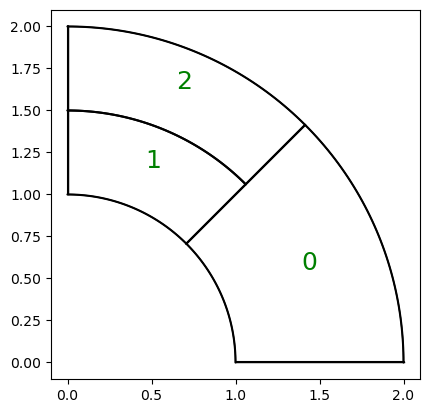

In [240]:
M.draw(patch_idx=1)

In [35]:
import pyMKL
solver = pyMKL.pardisoSolver(A, 11)
solver.factor()

In [38]:
solver.solve(RHS)

AttributeError: 'csc_matrix' object has no attribute 'flatten'

In [13]:
A = scipy.sparse.csc_matrix(np.array([[1,2],[3,4]]))

In [22]:
RHS = scipy.sparse.csc_matrix(np.array([[1,0],[0,1]]))

In [18]:
scipy.sparse.linalg.spsolve(A,scipy.sparse.csc_matrix(np.array([[1,0],[0,1]])))

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 4 stored elements and shape (2, 2)>

In [16]:
solvers.make_solver(A)@scipy.sparse.csc_matrix(np.array([[1,0],[0,1]]))

TypeError: Unable to multiply a LinearOperator with a sparse matrix. Wrap the matrix in aslinearoperator first.

In [44]:
IMap.N_ofs

array([ 0, 16, 32, 48])

In [153]:
I.SystemMatrix('csc')

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 356 stored elements and shape (60, 60)>

In [102]:
ISys.construct_primal_constraints()

In [103]:
ISys.construct_primal_basis()

AssertionError: Local system matrices have not been assembled yet!

In [56]:
ISys.eliminate_constraints

array([ 0,  3,  4,  8, 11,  7], dtype=int32)

In [68]:
print(IMap.B[7,:])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (1, 48)>
  Coords	Values
  (0, 31)	-1.0
  (0, 44)	1.0


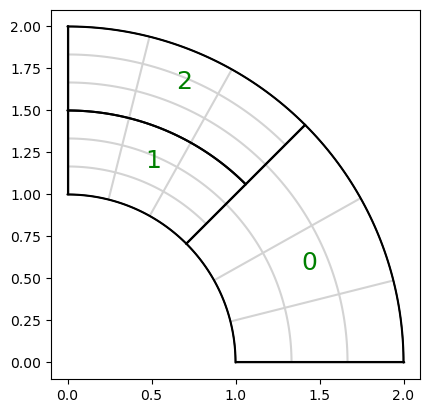

In [12]:
M.draw(knots=1, patch_idx=1)

In [125]:
corner = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=True) + MP.N_ofs[p] for p, kvs in enumerate(MP.mesh.kvs)])
n = MP.B.shape[1]

In [115]:
idx = (MP.B[:,corner]>0).getnnz(1)>0
B = MP.B[idx,:]
B = B[B.getnnz(1)==2,:]
loc_c = np.unique(B.indices)
R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),n)).tocsr()
c_B = B@R.T

R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),n)).tocsr()
nodal_indicator = algebra_cy.pyx_compute_basis(c_B.shape[0], c_B.shape[1], c_B, maxiter=5)
dofs = np.empty(nodal_indicator.shape[1], dtype=np.int32)
S = c_B.sum(0).A[0]
for j in range(nodal_indicator.shape[1]):
    ind = nodal_indicator.indices[nodal_indicator.indptr[j]:nodal_indicator.indptr[j+1]]
    dofs[j]=R.indices[ind[np.argmax(S[ind])]]
nodal_indicator = (R.T@nodal_indicator)[:,nodal_indicator.getnnz(axis=0)>1]
nnz = MP.B.getnnz(1)
B = MP.B.tocsc()
constr = np.repeat(-1,len(dofs))

for j in range(nodal_indicator.shape[1]):
    dof=dofs[j]
    for r in range(B.indptr[dof],B.indptr[dof+1]):
        i=B.indices[r]
        if nnz[i]>2:
            constr[j]=i
            break
if any(constr!=-1):
    idx = np.where(constr!=-1)[0]
    res = scipy.sparse.csc_matrix(nodal_indicator.shape)
    Q = scipy.sparse.spdiags(1*(constr!=-1),0,len(constr),len(constr))
    Q = scipy.sparse.coo_matrix((np.ones(len(idx)),(idx,np.arange(len(idx)))),(len(constr),len(idx)))
    res = (Q@abs(MP.B[constr[idx],:])).T
    res.data=abs(res.data-1)
    res.eliminate_zeros()
    nodal_indicator += res

In [116]:
np.array([nodal_indicator.indices, nodal_indicator.data])

array([[25.   , 20.   , 54.   , 24.   , 21.   , 22.   , 23.   , 50.   , 29.   , 70.   , 49.   ],
       [ 1.   ,  1.   ,  1.   ,  1.   ,  0.875,  0.25 ,  0.875,  1.   ,  1.   ,  1.   ,  1.   ]])

In [117]:
dofs= np.split(nodal_indicator.indices,nodal_indicator.indptr[1:-1])

In [118]:
coeffs =np.split(nodal_indicator.data,nodal_indicator.indptr[1:-1])

In [119]:
list(zip(dofs,coeffs))

[(array([25, 20], dtype=int32), array([1., 1.])),
 (array([54, 24], dtype=int32), array([1., 1.])),
 (array([21, 22, 23, 50, 29], dtype=int32),
  array([0.875, 0.25 , 0.875, 1.   , 1.   ])),
 (array([70, 49], dtype=int32), array([1., 1.]))]

In [17]:
nodal_indicator.indices[nodal_indicator.indptr[:-1]]

array([ 3, 12, 31, 32, 35], dtype=int32)

In [8]:
print(nodal_indicator[:,2])

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 2 stored elements and shape (64, 1)>
  Coords	Values
  (31, 0)	1.0
  (44, 0)	1.0


In [258]:
idx=np.where(constr!=-1)[0]

In [259]:
idx

array([2])

In [270]:
res = scipy.sparse.csc_matrix(nodal_indicator.shape)

In [274]:
res[:,idx]=abs(MP.B[constr[idx],:]).T

/home/wolfman/miniforge3/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [280]:
res.data=abs(res.data-1)

In [282]:
res.data

array([0.5, 0.5, 0. ])

In [272]:
abs(MP.B[constr[idx],:])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 81)>

In [273]:
res[:,idx]

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 0 stored elements and shape (81, 1)>

In [214]:
idx

array([-1, -1, -1, -1])

In [135]:
B.toarray()

array([[ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [120]:
np.argmax(np.array([-1,0,1]))

2

In [118]:
c_B[:,[2,4,6,10]].sum(0)

matrix([[-2.,  0.,  0.,  2.]])

In [92]:
nodal_indicator = (R.T@nodal_indicator)[:,nodal_indicator.getnnz(axis=0)>1]

In [88]:
c_B

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (4, 8)>

In [86]:
for j in range(nodal_indicator.shape[1]):
    ind = nodal_indicator.indices[nodal_indicator.indptr[j]:nodal_indicator.indptr[j+1]]
    

# dofs = nodal_indicator.indices
# nnz = MP.B.getnnz(1)
# B = MP.B.tocsc()
# idx = np.zeros(len(dofs))-1

# for k,dof in enumerate(dofs):
#     for r in range(B.indptr[dof],B.indptr[dof+1]):
#         i = B.indices[r]
#         if nnz[i]>2 and np.isclose(B.data[r],1): 
#             idx[k] = i
# #idx = MP.Constr[:,dofs].tocsc().indices
# #nnz = MP.Constr.getnnz(1)

[12 16]
[15 35]
[19 32]
[31 44]


In [87]:
ind

array([31, 44], dtype=int32)

In [82]:
dofs

array([12, 16, 15, 35, 19, 32, 31, 44], dtype=int32)

In [83]:
B[:,dofs].toarray()

array([[-1. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [-0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -1. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -1. ,  1. ,  0. ,  0. ,  0. ,  0. ]])

In [84]:
idx

array([-1., -1., -1., -1.,  3.,  8., -1., -1.])

In [54]:
print(B[:,12])

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 2 stored elements and shape (12, 1)>
  Coords	Values
  (0, 0)	-1.0
  (1, 0)	-0.5


In [25]:
B.indices[B.indptr[dofs[2]]:B.indptr[dofs[2]+1]]

array([3, 4], dtype=int32)

In [84]:
idx = MP.Constr[:,dofs].tocsc().indices

In [26]:
B[:,dofs].toarray()

array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [75]:
nnz

array([2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2], dtype=int32)

In [74]:
nnz

array([2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2], dtype=int32)

In [31]:
dofs

array([16, 35, 32, 44], dtype=int32)

In [41]:
B.toarray()

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.5, -0.5,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,

In [19]:
idx1 = MP.Constr.tocsc()[:,dofs].getnnz(1)>0

In [20]:
idx1

array([ True, False, False, False,  True, False, False,  True,  True, False, False,  True])

In [248]:
B = MP.Constr[idx,:]

In [249]:
B.toarray()

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.5, -0.5,  0. ,  0. ,

In [250]:
MP.Constr[idx,:][MP.Constr[idx,:].getnnz(1)>0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 11 stored elements and shape (5, 48)>

In [251]:
nodal_indicator.indptr[:-1]

array([0, 2, 4, 6], dtype=int32)

In [252]:
np.where(idx2)

(array([1, 2, 3, 4, 5]),)

In [126]:
idx2=np.unique(1*((MP.Constr@R.T@R)==1).tocsc().indices)
corner_dofs = np.unique(MP.Constr[idx2,:].indices)

In [127]:
corner_dofs

array([12, 13, 14, 15, 16, 19, 31, 32, 38, 74], dtype=int32)

In [125]:
np.unique(MP.Constr[idx2,:].indices)

array([12, 13, 14, 15, 16, 19, 31, 32, 38, 74], dtype=int32)

In [73]:
MP.Constr.data

array([-1. ,  1. , -0.5, -0.5,  1. , -1. ,  1. , -0.5, -0.5,  1. , -1. ,  1. , -1. ,  1. , -1. ,  1. , -1. ,  1. , -0.5, -0.5,  1. , -1. ,  1. , -0.5, -0.5,  1. , -1. ,  1. ])

In [44]:
MP.Constr.data[MP.Constr.data==-1]=0

In [47]:
MP.Constr[:,loc_c]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12 stored elements and shape (12, 12)>

In [45]:
MP.Constr[:,loc_c]+1*(MP.Constr[:,loc_c]!=0)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (12, 12)>

In [30]:
idx2 = (MP.Constr[:,loc_c].getnnz(axis=1)>0)

In [32]:
np.where(idx2)

(array([ 0,  1,  3,  4,  7,  8, 10, 11]),)

In [37]:
print((abs(MP.Constr)-1*(MP.Constr!=0))[idx2,:])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (8, 48)>
  Coords	Values
  (1, 12)	-0.5
  (1, 13)	-0.5
  (2, 13)	-0.5000000000000001
  (2, 14)	-0.5
  (5, 13)	-0.5000000000000001
  (5, 14)	-0.5
  (6, 14)	-0.4999999999999999
  (6, 15)	-0.5000000000000002


In [27]:
np.where(idx)

(array([ 0,  4,  7, 11]),)

In [385]:
c_Basis

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 16 stored elements and shape (36, 9)>

In [386]:
c_Basis[:,c_Basis.getnnz(axis=0)>1]

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 12 stored elements and shape (36, 5)>

In [387]:
dofs = c_Basis[:,c_Basis.getnnz(axis=0)>1].indices

In [388]:
sec = c_Basis[:,c_Basis.getnnz(axis=0)>1].indptr

In [389]:
dofs

array([27,  2,  9,  6, 24, 17, 33, 18, 11,  8, 35, 20], dtype=int32)

In [390]:
sec

array([ 0,  2,  4,  6, 10, 12], dtype=int32)

In [391]:
np.split(dofs, sec[1:-1])

[array([27,  2], dtype=int32),
 array([9, 6], dtype=int32),
 array([24, 17], dtype=int32),
 array([33, 18, 11,  8], dtype=int32),
 array([35, 20], dtype=int32)]

In [19]:
# x = np.zeros(n)
# x[loc_c] = 1
# R = scipy.sparse.spdiags(x,0,n,n)
# B_ = MP.Constr@R

In [20]:
#fine_dofs = np.unique((B_==1).tocsr().indices)

In [21]:
#np.unique(fine_dofs)

In [22]:
#idx2 = np.unique(MP.Constr[:,fine_dofs].tocsc().indices)

In [23]:
#B = MP.Constr[idx2,:]

In [24]:
#B[B.getnnz(1)>2].toarray()

In [25]:
Basis = algebra_cy.pyx_compute_basis(B.shape[0], B.shape[1], B, maxiter=5).tocsc()

In [26]:
Basis = Basis[:,Basis.getnnz(axis=0)>1]

In [27]:
Basis.shape

(48, 5)

In [28]:
Basis.toarray()

array([[0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0

In [450]:
fine_dofs = Basis.indices[Basis.indptr[:-1]]

In [235]:
sys.setrecursionlimit(100000)
N = 1000
A = np.random.rand(N,N)
L = 10000*[aslinearoperator(A)]
S = np.array(L).sum()
x = np.random.rand(N)

In [236]:
%timeit S@x

550 ms ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [237]:
X = SumOperator(L)

In [238]:
%timeit X@x

505 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [221]:
X

<3x2 SumOperator with dtype=int64>

In [154]:
L[0].dtype

dtype('int64')

In [140]:
np.all((np.array([s.shape for s in L])-np.tile(L[0].shape,len(L)).reshape(-1,2))==0)

True

In [198]:
class SumOperator(scipy.sparse.linalg.LinearOperator):
    """A :class:`LinearOperator` which implements the 
    application of an arbitrary sum of given input operators 
    without(!) using recursive structures.
    """
    def __init__(self, ops):
        self.N = len(ops)
        assert np.all((np.array([op.shape for op in ops])-np.tile(ops[0].shape,self.N).reshape(-1,2))==0)
        self.ops = ops
        self.shape = ops[0].shape
        scipy.sparse.linalg.LinearOperator.__init__(self, ops[0].dtype, self.shape)
        
    def _matvec(self, x):
        return np.array([op@x for op in self.ops]).sum(axis=0)

    def _transpose(self):
        return SumOperator([op.T for op in self.ops])
        

In [128]:
np.all(np.array([1,1,1])==1)

True

In [136]:
np.tile(L[0].shape,len(L)).reshape(-1,2)

array([[3, 2],
       [3, 2],
       [3, 2]])